# Completion profiling

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pyquickhelper.ipythonhelper import add_notebook_menu
add_notebook_menu()

## Setup

### Function to profile

In [ ]:
from mlstatpy.nlp.completion import CompletionTrieNode

def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(weights) * 1.0
    res = []
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w) - trie.min_dynamic_keystroke(w)[0])
               for p, w in per]
    wks_dyn2 = [(w, p, len(w) - trie.min_dynamic_keystroke2(w)[0])
                for p, w in per]
    gain = sum(g * p / total for w, p, g in wks)
    gain_dyn = sum(g * p / total for w, p, g in wks_dyn)
    gain_dyn2 = sum(g * p / total for w, p, g in wks_dyn2)
    ave_length = sum(len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length

### Data

In [ ]:
from mlstatpy.data.wikipedia import download_titles
file_titles = download_titles(country='fr')

In [ ]:
from mlstatpy.data.wikipedia import enumerate_titles
list_titles = list(sorted(set(_ for _ in enumerate_titles(file_titles) if 'A' <= _[0] <= 'Z')))

In [ ]:
import random
sample1000 = random.sample(list_titles, 1000)
with open("sample1000.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(sample1000))

## Standard modules

### cProfile

In [ ]:
import cProfile, io, pstats, os

def toprofile0(lines):
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))

def doprofile(lines, filename):
    pr = cProfile.Profile()
    pr.enable()
    toprofile0(lines)
    pr.disable()
    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
    ps.print_stats()
    rem = os.path.normpath(os.path.join(os.getcwd(), "..", "..", ".."))
    res = s.getvalue().replace(rem, "")
    ps.dump_stats(filename)
    return res

In [ ]:
r = doprofile(sample1000, "completion.prof")
print(r)

         1202865 function calls in 1.583 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.583    1.583 <ipython-input-6-ff8ba7222a38>:3(toprofile0)
        1    0.071    0.071    1.583    1.583 <ipython-input-2-1cd63cc92e3c>:3(gain_dynamique_moyen_par_mot)
        1    0.139    0.139    1.067    1.067 \src\mlstatpy\nlp\completion.py:416(precompute_stat)
    14978    0.443    0.000    0.804    0.000 \src\mlstatpy\nlp\completion.py:504(merge_completions)
        1    0.066    0.066    0.272    0.272 \src\mlstatpy\nlp\completion.py:451(update_stat_dynamic)
    14978    0.195    0.000    0.199    0.000 {built-in method builtins.__build_class__}
        1    0.115    0.115    0.140    0.140 \src\mlstatpy\nlp\completion.py:203(build)
    15977    0.074    0.000    0.134    0.000 \src\mlstatpy\nlp\completion.py:556(update_dynamic_minimum_keystroke)
    33867    0.086    0.000    0.093    0.000 \sr

## Others informations when profiling

### memory_profiler

See [memory_profiler](https://pypi.python.org/pypi/memory_profiler/0.41).

In [ ]:
from memory_profiler import profile
%load_ext memory_profiler

In [ ]:
%memit toprofile0(sample1000)

peak memory: 363.25 MiB, increment: 22.06 MiB


In [ ]:
from io import StringIO
st = StringIO()
@profile(stream=st)
def toprofile(lines):
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))
toprofile(sample1000)

ERROR: Could not find file <ipython-input-10-7e3f7b9a5136>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.


In [ ]:
%%file temp_mem_profile.py

from mlstatpy.nlp.completion import CompletionTrieNode
from memory_profiler import profile

@profile(precision=4)
def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(weights) * 1.0
    res = []
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w) - trie.min_dynamic_keystroke(w)[0])
               for p, w in per]
    wks_dyn2 = [(w, p, len(w) - trie.min_dynamic_keystroke2(w)[0])
                for p, w in per]
    gain = sum(g * p / total for w, p, g in wks)
    gain_dyn = sum(g * p / total for w, p, g in wks_dyn)
    gain_dyn2 = sum(g * p / total for w, p, g in wks_dyn2)
    ave_length = sum(len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length

@profile(precision=4)
def toprofile():
    with open("sample1000.txt", "r", encoding="utf-8") as f:
        lines = [_.strip("\n\r ") for _ in f.readlines()]
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))
toprofile()

Overwriting temp_mem_profile.py


In [ ]:
import sys
cmd = sys.executable
from pyquickhelper.loghelper import run_cmd
cmd += " -m memory_profiler temp_mem_profile.py"
out, err = run_cmd(cmd, wait=True)
print(out)

Filename: temp_mem_profile.py

Line #    Mem usage    Increment   Line Contents
     5  41.0000 MiB   0.0000 MiB   @profile(precision=4)
     6                             def gain_dynamique_moyen_par_mot(queries, weights):
     7  41.0195 MiB   0.0195 MiB       per = list(zip(weights, queries))
     8  41.0195 MiB   0.0000 MiB       total = sum(weights) * 1.0
     9  41.0195 MiB   0.0000 MiB       res = []
    10  47.9805 MiB   6.9609 MiB       trie = CompletionTrieNode.build([(None, q) for _, q in per])
    11  56.5469 MiB   8.5664 MiB       trie.precompute_stat()
    12  65.9961 MiB   9.4492 MiB       trie.update_stat_dynamic()
    13  66.0977 MiB   0.1016 MiB       wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    14  66.1719 MiB   0.0742 MiB       wks_dyn = [(w, p, len(w) - trie.min_dynamic_keystroke(w)[0])
    15  66.1719 MiB   0.0000 MiB                  for p, w in per]
    16  66.2500 MiB   0.0781 MiB       wks_dyn2 = [(w, p, len(w) - trie.min_dynamic_keys

### line_profiler

See [line_profiler](https://github.com/rkern/line_profiler).

In [ ]:
def lineprofile(lines):
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))

In [ ]:
from mlstatpy.nlp.completion import CompletionTrieNode

In [ ]:
from line_profiler import LineProfiler
prof = LineProfiler()
prof.add_function(gain_dynamique_moyen_par_mot)
prof.add_function(CompletionTrieNode.precompute_stat)
prof.run("lineprofile(sample1000)")
st = io.StringIO()
prof.print_stats(stream=st)
rem = os.path.normpath(os.path.join(os.getcwd(), "..", "..", ".."))
res = st.getvalue().replace(rem, "")
print(res)

Timer unit: 4.27635e-07 s

Total time: 3.18466 s
File: <ipython-input-2-1cd63cc92e3c>
Function: gain_dynamique_moyen_par_mot at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def gain_dynamique_moyen_par_mot(queries, weights):
     4         1          696    696.0      0.0      per = list(zip(weights, queries))
     5         1           29     29.0      0.0      total = sum(weights) * 1.0
     6         1            6      6.0      0.0      res = []
     7         1       392977 392977.0      5.3      trie = CompletionTrieNode.build([(None, q) for _, q in per])
     8         1      5491307 5491307.0     73.7      trie.precompute_stat()
     9         1      1352633 1352633.0     18.2      trie.update_stat_dynamic()
    10         1        63050  63050.0      0.8      wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    11         1           14     14.0      0.0      wks_dyn = [(w, p, len(w) -

## Static Visualization

### gprof2dot

See [gprof2dot](https://github.com/jrfonseca/gprof2dot).

In [ ]:
import gprof2dot
import sys
sys.argv=["", "-f", "pstats", "completion.prof", "-o", "completion.dot"]
gprof2dot.main()

In [ ]:
from pyquickhelper.helpgen.conf_path_tools import find_graphviz_dot
dot = find_graphviz_dot()

In [ ]:
from pyquickhelper.loghelper import run_cmd
out, err = run_cmd('"{0}" completion.dot -Tpng -ocompletion.png'.format(dot), wait=True)
print(out)

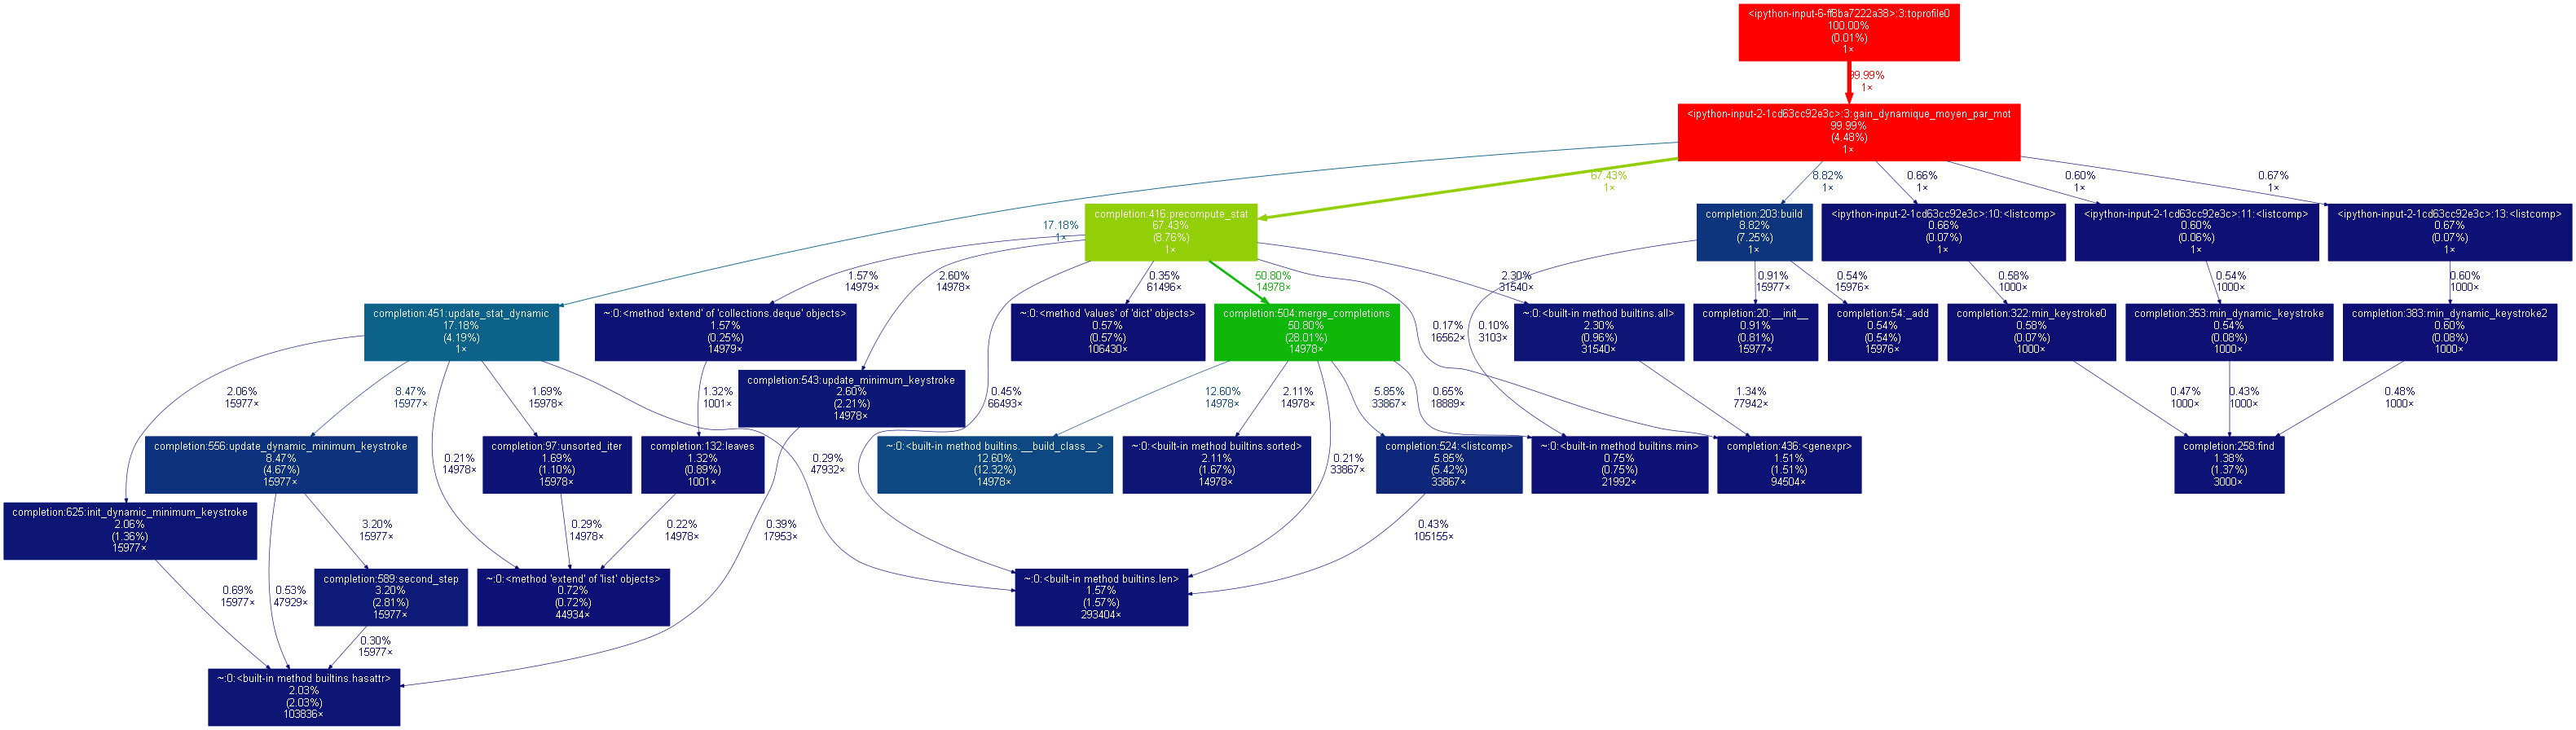

In [ ]:
from IPython.display import Image
Image("completion.png")

### pyinstrument

See [pyinstrument](https://github.com/joerick/pyinstrument).

In [ ]:
from pyinstrument import Profiler

profiler = Profiler(use_signal=False)
profiler.start()

toprofile0(sample1000)

profiler.stop()

print(profiler.output_text(unicode=True, color=True).encode("ascii", errors="ignore").decode("ascii", errors="ignore"))

3.769 gain_dynamique_moyen_par_mot  <ipython-input-2-1cd63cc92e3c>:3
 2.529 precompute_stat  mlstatpy\nlp\completion.py:416
   1.704 merge_completions  mlstatpy\nlp\completion.py:504
     0.293 <listcomp>  mlstatpy\nlp\completion.py:524
   0.091 leaves  mlstatpy\nlp\completion.py:132
   0.082 update_minimum_keystroke  mlstatpy\nlp\completion.py:543
   0.080 <genexpr>  mlstatpy\nlp\completion.py:436
 0.975 update_stat_dynamic  mlstatpy\nlp\completion.py:451
   0.479 update_dynamic_minimum_keystroke  mlstatpy\nlp\completion.py:556
     0.189 second_step  mlstatpy\nlp\completion.py:589
   0.121 unsorted_iter  mlstatpy\nlp\completion.py:97
   0.063 init_dynamic_minimum_keystroke  mlstatpy\nlp\completion.py:625
 0.197 build  mlstatpy\nlp\completion.py:203
    0.061 __init__  mlstatpy\nlp\completion.py:20



## Javascript Visualization

### SnakeViz

In [ ]:
%load_ext snakeviz

L'instruction qui suit lance l'explorateur par défaut avec les données du profilage.

In [ ]:
# %snakeviz toprofile0(sample1000)

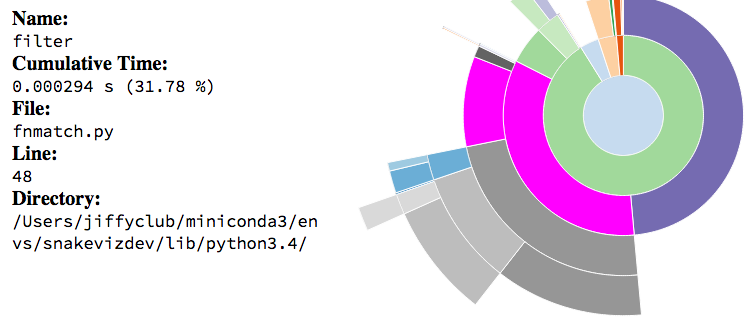

In [ ]:
from IPython.display import Image
Image("https://jiffyclub.github.io/snakeviz/img/func_info.png")

### vprof

See [vprof](https://github.com/nvdv/vprof).

In [ ]:
from vprof import profiler

# needs to be run from a file not from a notebook
# profiler.run(toprofile0, 'cmh', args=(sample1000,), host='localhost', port=8000)

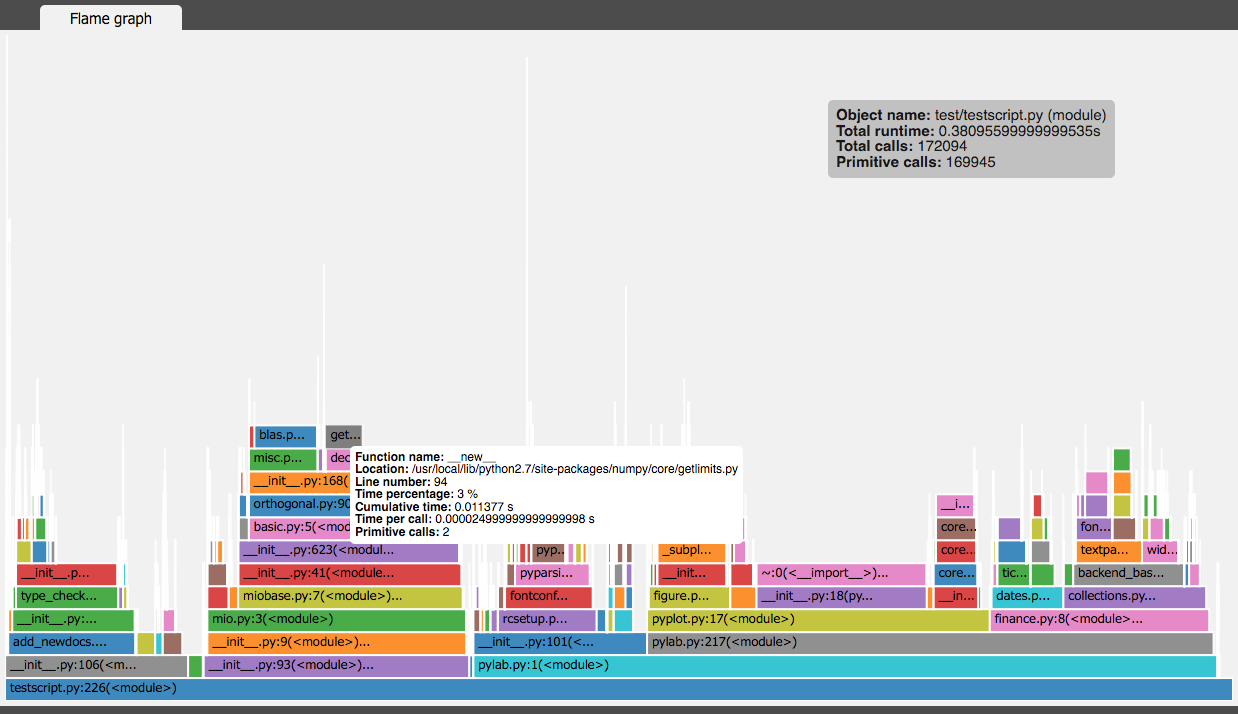

In [ ]:
Image("http://i.imgur.com/ijC7wmj.png")